In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

In [3]:
vader_file = 'D:/SKRIPSI/skenario4/labelling_skenario4.xlsx'  # Ganti dengan file hasil labelling VADER
tfidf_file = 'D:/SKRIPSI/tfidf_final.xlsx'  # Ganti dengan file hasil TF-IDF

In [4]:
vader_df = pd.read_excel(vader_file)
tfidf_df = pd.read_excel(tfidf_file)

In [5]:
sentiment_mapping = {'Positive': 1, 'Negative': -1}
vader_df['VADER Sentiment'] = vader_df['VADER Sentiment'].map(sentiment_mapping)

In [6]:
X = tfidf_df.drop(columns=["Comment_ID"])
y = vader_df["VADER Sentiment"].squeeze()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [10]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC

# Balancing data
ros = RandomOverSampler(random_state=42)
X_train_balanced, y_train_balanced = ros.fit_resample(X_train, y_train)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("=== Random Forest ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

=== Random Forest ===
Accuracy: 0.7378640776699029

Classification Report:
               precision    recall  f1-score   support

          -1       0.68      0.36      0.47       100
           1       0.75      0.92      0.83       209

    accuracy                           0.74       309
   macro avg       0.71      0.64      0.65       309
weighted avg       0.73      0.74      0.71       309




=== Support Vector Machine (SVM) dengan Kernel: linear ===
Accuracy: 0.7411003236245954

Classification Report:
               precision    recall  f1-score   support

          -1       0.59      0.65      0.62       100
           1       0.82      0.78      0.80       209

    accuracy                           0.74       309
   macro avg       0.71      0.72      0.71       309
weighted avg       0.75      0.74      0.74       309



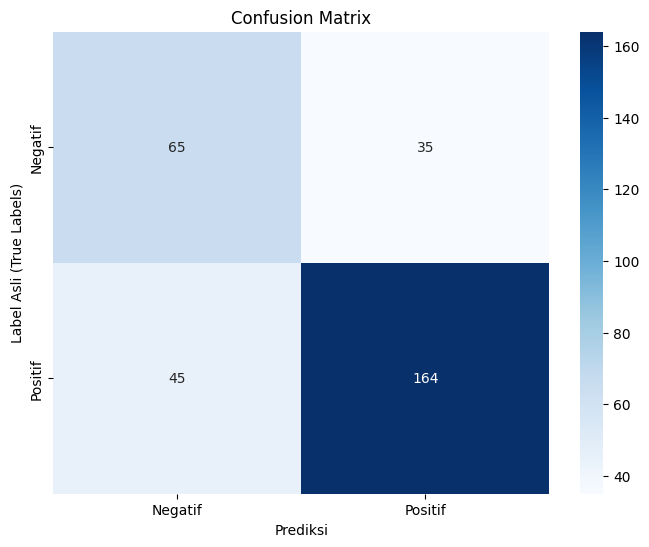

✅ Model SVM berhasil disimpan dalam file svm_model_balanced.pkl

Data testing telah disimpan ke file 'predict_results.xlsx'.


In [17]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC

# Balancing data
ros = RandomOverSampler(random_state=42)
X_train_balanced, y_train_balanced = ros.fit_resample(X_train, y_train)

# Daftar kernel yang ingin diuji
kernels = ['linear']

# Uji SVM dengan semua kernel
for kernel in kernels:
    print(f"\n=== Support Vector Machine (SVM) dengan Kernel: {kernel} ===")
    
    # Membuat model SVM dengan kernel yang sesuai
    svm_model = SVC(kernel=kernel, random_state=42)
    svm_model.fit(X_train_balanced, y_train_balanced)  # Melatih model pakai data yang sudah dibalancing
    y_pred_svm = svm_model.predict(X_test)  # Prediksi tetap dari X_test

    # Hitung akurasi
    acc = accuracy_score(y_test, y_pred_svm)
    print("Accuracy:", acc)

    # Tampilkan classification report
    print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))

    # Menghitung confusion matrix
    cm = confusion_matrix(y_test, y_pred_svm)

    # Visualisasi Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negatif", "Positif"], yticklabels=["Negatif", "Positif"])
    plt.title('Confusion Matrix')
    plt.xlabel('Prediksi')
    plt.ylabel('Label Asli (True Labels)')
    plt.show()

    # Simpan model SVM
    model_filename = 'svm_model_balanced.pkl'
    joblib.dump(svm_model, model_filename)
    print(f"✅ Model SVM berhasil disimpan dalam file {model_filename}")
    
    # Membuat DataFrame dari data testing
test_results = pd.DataFrame(X_test)  # Data fitur tanpa TF-IDF, jika X_test sudah berupa DataFrame

# Menambahkan kolom Comment_ID (misalnya ID berdasarkan urutan baris)
test_results['Comment_ID'] = test_results.index  # Menambahkan Comment_ID berdasarkan index (urutan baris)

# Menambahkan kolom 'Aktual' dan 'Prediksi'
test_results['Aktual'] = y_test
test_results['Prediksi'] = y_pred_svm

# Menyimpan ke file Excel dengan kolom Comment_ID, Aktual, dan Prediksi
test_results = test_results[['Comment_ID', 'Aktual', 'Prediksi']]  # Hanya kolom yang dibutuhkan

# Menyimpan ke file Excel
test_results.to_excel("predict_results.xlsx", index=False)
print("\nData testing telah disimpan ke file 'predict_results.xlsx'.")

In [18]:
import joblib

# Setelah training selesai
joblib.dump(svm_model, 'svm_model_linear.pkl')
print("✅ Model SVM telah disimpan.")


✅ Model SVM telah disimpan.


In [ ]:
import pandas as pd
import joblib
import emoji
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize

# Definisikan lagi fungsi custom_tokenizer
def custom_tokenizer(text):
    tokens = word_tokenize(text)
    emojis = [char for char in text if char in emoji.EMOJI_DATA]
    return tokens + emojis

# Load model TF-IDF yang sudah dilatih
tfidf_vectorizer = joblib.load('tfidf_model.pkl')

# Load model SVM yang sudah dilatih
svm_model = joblib.load('svm_model_linear.pkl')

# Fungsi untuk memproses input dan prediksi
def prediksi_sentimen(kalimat):
    # Transformasi kalimat menggunakan TF-IDF
    kalimat_tfidf = tfidf_vectorizer.transform([kalimat]).toarray()  # <<< TAMBAHKAN .toarray()
    
    # Prediksi sentimen menggunakan model SVM
    prediksi = svm_model.predict(kalimat_tfidf)
    
    return prediksi[0]

# Ambil input dari pengguna (atau langsung isi string)
kalimat_input = input("Masukkan Kalimat: ")  # Kalau mau input manual: input("Masukkan kalimat: ")

# Panggil fungsi untuk prediksi
hasil_prediksi = prediksi_sentimen(kalimat_input)

# Tampilkan hasil prediksi
if hasil_prediksi == 1:
    print("Sentimen Prediksi: Positif")
else:
    print("Sentimen Prediksi: Negatif")
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")



=== Support Vector Machine (SVM) dengan Kernel: linear ===
Accuracy: 0.7831715210355987

Classification Report:
               precision    recall  f1-score   support

          -1       0.70      0.57      0.63       100
           1       0.81      0.89      0.85       209

    accuracy                           0.78       309
   macro avg       0.76      0.73      0.74       309
weighted avg       0.78      0.78      0.78       309



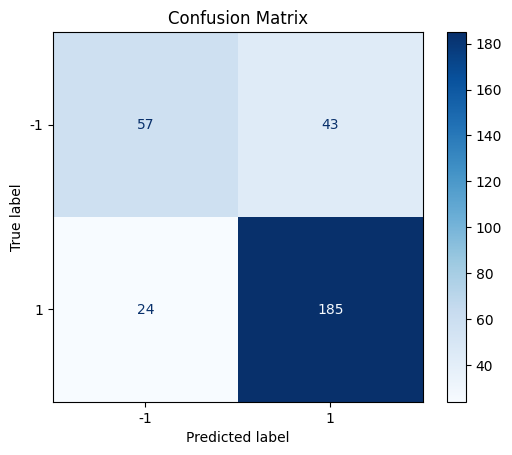

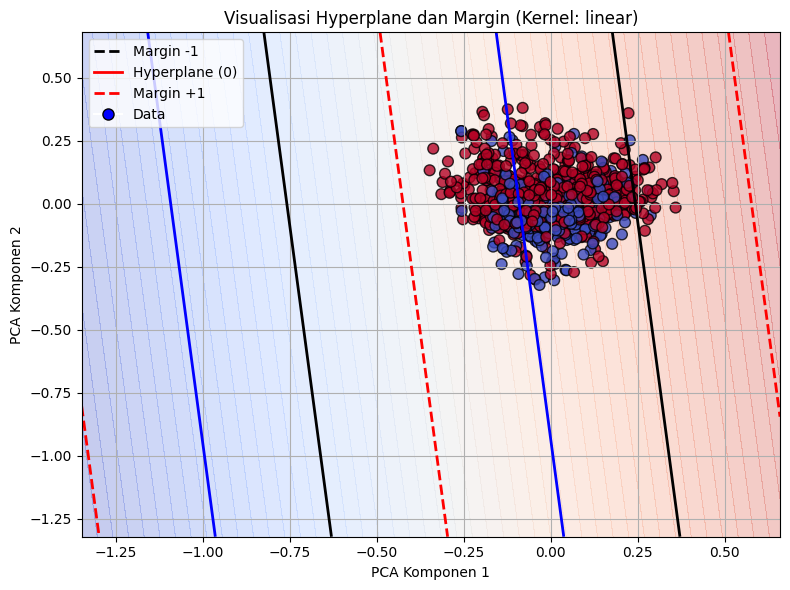

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from matplotlib.lines import Line2D

# ================= SVM Linear + PCA Visualisasi =================
kernel = 'linear'
print(f"\n=== Support Vector Machine (SVM) dengan Kernel: {kernel} ===")

# Latih model SVM (fit ke data asli)
svm_model = SVC(kernel=kernel, random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# Evaluasi model
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svm, labels=svm_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# ================= PCA untuk Visualisasi =================
pca = PCA(n_components=2)
X_train_2D = pca.fit_transform(X_train.values)
X_test_2D = pca.transform(X_test.values)

# Latih ulang SVM dengan data hasil PCA (2D)
svm_2D = SVC(kernel=kernel, random_state=42)
svm_2D.fit(X_train_2D, y_train)

# Grid untuk visualisasi decision boundary
x_min, x_max = X_train_2D[:, 0].min() - 1, X_train_2D[:, 0].max() + 0.3
y_min, y_max = X_train_2D[:, 1].min() - 1, X_train_2D[:, 1].max() + 0.3
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))

# Hitung decision function untuk setiap titik di grid
Z = svm_2D.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Encode label untuk pewarnaan titik
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_train)

# Visualisasi
plt.figure(figsize=(8, 6))

# Background kelas berdasarkan decision function
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 50), cmap='coolwarm', alpha=0.3)

# Gambar hyperplane dan margin
plt.contour(xx, yy, Z,
            colors=['black', 'red', 'blue'], 
            linestyles=['-', '--', '-'], 
            linewidths=2)


# Scatter plot data
plt.scatter(X_train_2D[:, 0], X_train_2D[:, 1],
            c=y_encoded, cmap='coolwarm', edgecolors='k', s=60, alpha=0.8)

# Tambahkan legend secara manual
legend_elements = [
    Line2D([0], [0], color='black', linestyle='--', lw=2, label='Margin -1'),
    Line2D([0], [0], color='red', linestyle='-', lw=2, label='Hyperplane (0)'),
    Line2D([0], [0], color='red', linestyle='--', lw=2, label='Margin +1'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', label='Data', markeredgecolor='k', markersize=8)
]
plt.legend(handles=legend_elements)

# Judul dan label
plt.title(f"Visualisasi Hyperplane dan Margin (Kernel: {kernel})")
plt.xlabel("PCA Komponen 1")
plt.ylabel("PCA Komponen 2")
plt.grid(True)
plt.tight_layout()
plt.show()


In [85]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd

# Daftar kernel yang ingin diuji
kernels = ['linear']

# Uji SVM dengan semua kernel
for kernel in kernels:
    print(f"\n=== Support Vector Machine (SVM) dengan Kernel: {kernel} ===")
    
    # Membuat model SVM dengan kernel yang sesuai
    svm_model = SVC(kernel=kernel, random_state=42)
    svm_model.fit(X_train, y_train)  # Melatih model
    y_pred_svm = svm_model.predict(X_test)  # Prediksi

    # Hitung akurasi
    acc = accuracy_score(y_test, y_pred_svm)
    print("Accuracy:", acc)

    # Tampilkan classification report
    print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))
    
    # Kalau kernel linear, tampilkan bobot, bias, dan margin
    if kernel == 'linear':
        w = svm_model.coef_[0]   # ambil bobot
        b = svm_model.intercept_[0]  # ambil bias
        
        # Hitung margin
        norm_w = np.linalg.norm(w)
        margin = 2 / norm_w
        
        print("\n=== Informasi Linear SVM ===")
        print("Bias (b):", b)
        print("Margin:", margin)
        
        # Simpan bobot ke Excel, walaupun sedikit
        df_w = pd.DataFrame(w, columns=['Weight'])
        excel_filename = f"bobot_svm_{kernel}.xlsx"
        df_w.to_excel(excel_filename, index=False)
        print(f"Bobot disimpan ke file '{excel_filename}'")



=== Support Vector Machine (SVM) dengan Kernel: linear ===
Accuracy: 0.7831715210355987

Classification Report:
               precision    recall  f1-score   support

          -1       0.70      0.57      0.63       100
           1       0.81      0.89      0.85       209

    accuracy                           0.78       309
   macro avg       0.76      0.73      0.74       309
weighted avg       0.78      0.78      0.78       309


=== Informasi Linear SVM ===
Bias (b): -0.21870619602151856
Margin: 0.089396787873101
Bobot disimpan ke file 'bobot_svm_linear.xlsx'


In [11]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC

# Balancing data
ros = RandomOverSampler(random_state=42)
X_train_balanced, y_train_balanced = ros.fit_resample(X_train, y_train)
# ====== Model Naïve Bayes ======
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

print("\n=== Naïve Bayes ===")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))


=== Naïve Bayes ===
Accuracy: 0.6828478964401294

Classification Report:
               precision    recall  f1-score   support

          -1       0.67      0.04      0.08       100
           1       0.68      0.99      0.81       209

    accuracy                           0.68       309
   macro avg       0.67      0.52      0.44       309
weighted avg       0.68      0.68      0.57       309



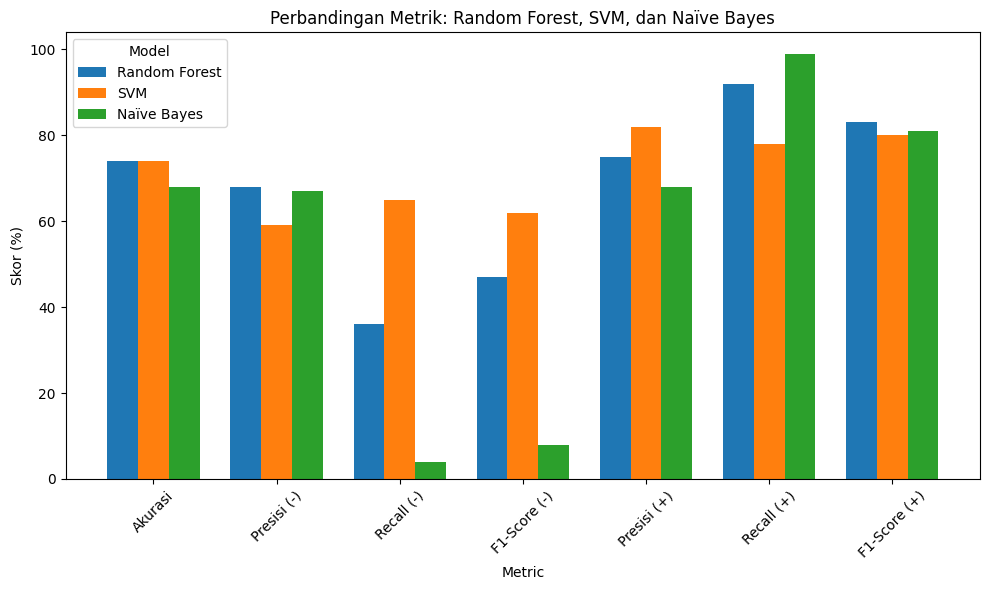

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Membuat DataFrame dengan data yang kamu berikan
data = {
    'Metric': ['Akurasi', 'Presisi (-)', 'Recall (-)', 'F1-Score (-)', 'Presisi (+)', 'Recall (+)', 'F1-Score (+)'],
    'Random Forest': [74, 68, 36, 47, 75, 92, 83],
    'SVM': [74, 59, 65, 62, 82, 78, 80],
    'Naïve Bayes': [68, 67, 4, 8, 68, 99, 81]
}

df = pd.DataFrame(data)

# Membuat plot
fig, ax = plt.subplots(figsize=(10, 6))

# Menentukan lebar bar dan posisi
bar_width = 0.25
index = range(len(df))

# Plotkan data untuk setiap model
ax.bar([x - bar_width for x in index], df['Random Forest'], bar_width, label='Random Forest')
ax.bar(index, df['SVM'], bar_width, label='SVM')
ax.bar([x + bar_width for x in index], df['Naïve Bayes'], bar_width, label='Naïve Bayes')

# Menambahkan label dan title
ax.set_xlabel('Metric')
ax.set_ylabel('Skor (%)')
ax.set_title('Perbandingan Metrik: Random Forest, SVM, dan Naïve Bayes')
ax.set_xticks(index)
ax.set_xticklabels(df['Metric'], rotation=45)
ax.legend(title="Model")

# Menampilkan plot
plt.tight_layout()
plt.show()


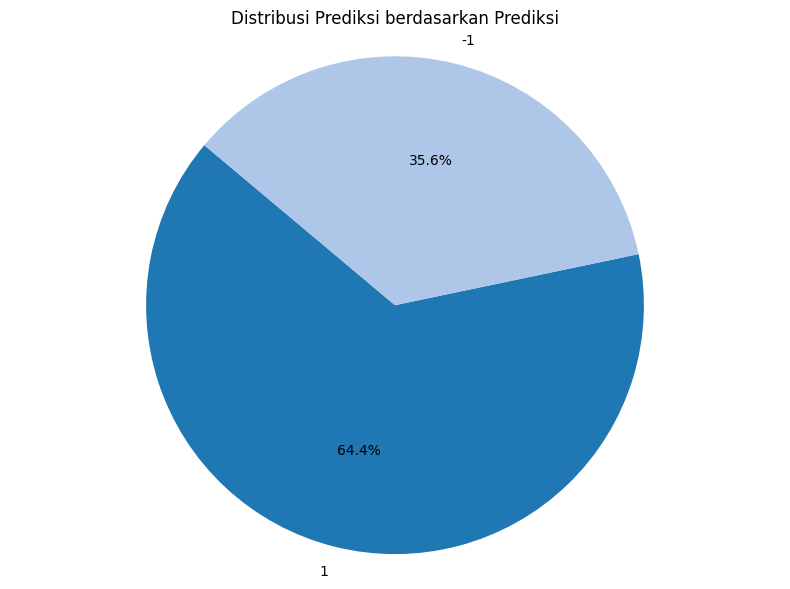

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# === Step 1: Load data dari file Excel ===
file_path = 'D:/SKRIPSI/predict_results_with_comments.xlsx'  # Ganti dengan path file kamu
sheet_name = 0  # Bisa pakai nama sheet atau index (default 0)

# Baca data
df = pd.read_excel(file_path, sheet_name=sheet_name)

# === Step 2: Pilih kolom prediksi ===
Prediksi = 'Prediksi'  # Ganti dengan nama kolom kamu
if Prediksi not in df.columns:
    raise ValueError(f"Kolom '{Prediksi}' tidak ditemukan di file Excel!")

# === Step 3: Hitung jumlah kategori ===
jumlah_kategori = df[Prediksi].value_counts()

# === Step 4: Buat Pie Chart ===
plt.figure(figsize=(8, 6))
plt.pie(jumlah_kategori, labels=jumlah_kategori.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
plt.title(f'Distribusi Prediksi berdasarkan {Prediksi}')
plt.axis('equal')  # Biar pie chart bulat
plt.tight_layout()
plt.show()
